In [67]:
from basketball_reference_scraper.seasons import get_schedule

games = get_schedule(2022)

games

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS
0,2021-10-19,Brooklyn Nets,104.0,Milwaukee Bucks,127.0
1,2021-10-19,Golden State Warriors,121.0,Los Angeles Lakers,114.0
2,2021-10-20,Indiana Pacers,122.0,Charlotte Hornets,123.0
3,2021-10-20,Chicago Bulls,94.0,Detroit Pistons,88.0
4,2021-10-20,Boston Celtics,134.0,New York Knicks,138.0
...,...,...,...,...,...
1225,2022-04-10,Los Angeles Lakers,NaN,Denver Nuggets,NaN
1226,2022-04-10,San Antonio Spurs,NaN,Dallas Mavericks,NaN
1227,2022-04-10,Milwaukee Bucks,NaN,Cleveland Cavaliers,NaN
1228,2022-04-10,Washington Wizards,NaN,Charlotte Hornets,NaN


In [68]:
import os
import time
from basketball_reference_scraper.shot_charts import get_shot_chart
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR

i = 0
for index, game in games.iterrows():
    gameTime = str(game["DATE"]).split(" ")[0]
    homeTeam = TEAM_TO_TEAM_ABBR[game["HOME"].upper()]
    awayTeam = TEAM_TO_TEAM_ABBR[game["VISITOR"].upper()]
    fileName = gameTime + "_" + homeTeam + ".csv"
    if os.path.exists("games/" + fileName):
        print("Game: " + fileName + " already exists")
        continue
    
    try:
        print("Downloading: " + fileName)
        df = get_shot_chart(gameTime, homeTeam, awayTeam)
        df[homeTeam]['relevant_team'] = homeTeam
        df[awayTeam]['relevant_team'] = awayTeam
        dfCombined = df[homeTeam].append(df[awayTeam])
        dfCombined["period_type"] = 'QUARTER'
        dfCombined["remaining_seconds_in_period"] = dfCombined['TIME_REMAINING'].apply(lambda x: sum(float(x) * 60 ** i for i, x in enumerate(reversed(str(x).split(':')))))
        dfCombined["home_team"] = homeTeam
        dfCombined["away_team"] = awayTeam
        dfCombined.rename(columns={'QUARTER': 'period', 'VALUE': 'shot_type', 'MAKE_MISS': 'shot_result', 'PLAYER': 'player'}, inplace=True)
        dfCombined.drop(columns=['TIME_REMAINING', 'x', 'y', 'DISTANCE'], inplace=True)
        dfCombined = dfCombined[['period','period_type','remaining_seconds_in_period','relevant_team','away_team','home_team','player','shot_type','shot_result']]
        dfCombined.to_csv("games/" + fileName, index=False)
        i += 1

        time.sleep(0.2)
    except:
        print("Error: " + fileName)
        break

print("Downloaded " + str(i) + " games")

Game: 2021-10-19_MIL.csv already exists
Game: 2021-10-19_LAL.csv already exists
Game: 2021-10-20_CHO.csv already exists
Game: 2021-10-20_DET.csv already exists
Game: 2021-10-20_NYK.csv already exists
Game: 2021-10-20_TOR.csv already exists
Game: 2021-10-20_MEM.csv already exists
Game: 2021-10-20_MIN.csv already exists
Game: 2021-10-20_NOP.csv already exists
Game: 2021-10-20_SAS.csv already exists
Game: 2021-10-20_UTA.csv already exists
Game: 2021-10-20_POR.csv already exists
Game: 2021-10-20_PHO.csv already exists
Game: 2021-10-21_ATL.csv already exists
Game: 2021-10-21_MIA.csv already exists
Game: 2021-10-21_GSW.csv already exists
Game: 2021-10-22_ORL.csv already exists
Game: 2021-10-22_WAS.csv already exists
Game: 2021-10-22_CLE.csv already exists
Game: 2021-10-22_BOS.csv already exists
Game: 2021-10-22_PHI.csv already exists
Game: 2021-10-22_HOU.csv already exists
Game: 2021-10-22_CHI.csv already exists
Game: 2021-10-22_DEN.csv already exists
Game: 2021-10-22_LAL.csv already exists


In [69]:
import os
import glob
import pandas as pd

all_filenames = [i for i in glob.glob('games/[0-9AZ]*.{}'.format('csv'))]

combined_csv = pd.DataFrame()

#combine all files in the list
for f in all_filenames:
    df = pd.read_csv(f)
    df.insert(0, 'game_id', f.split('\\')[1].split('.')[0])
    combined_csv = pd.concat([combined_csv, df])

#export to csv
combined_csv.to_csv("combined_games.csv", index=False, encoding='utf-8')

In [70]:
#import findspark
#findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NBA_Data").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

dfAll = spark.read.format("csv").option("header", "true").load("combined_games.csv")

dfAll.createOrReplaceTempView("all_shots")

dfAll.show(10)

+--------------+------+-----------+---------------------------+-------------+---------+---------+-----------------+---------+-----------+
|       game_id|period|period_type|remaining_seconds_in_period|relevant_team|away_team|home_team|           player|shot_type|shot_result|
+--------------+------+-----------+---------------------------+-------------+---------+---------+-----------------+---------+-----------+
|2021-10-19_LAL|   1.0|    QUARTER|                      713.0|          LAL|      GSW|      LAL|   DeAndre Jordan|      2.0|       MAKE|
|2021-10-19_LAL|   1.0|    QUARTER|                      665.0|          LAL|      GSW|      LAL|    Anthony Davis|      3.0|       MISS|
|2021-10-19_LAL|   1.0|    QUARTER|                      647.0|          LAL|      GSW|      LAL|Russell Westbrook|      2.0|       MISS|
|2021-10-19_LAL|   1.0|    QUARTER|                      624.0|          LAL|      GSW|      LAL|Russell Westbrook|      3.0|       MISS|
|2021-10-19_LAL|   1.0|    QUARTER

In [71]:
# Shot breakdown for first 3 mins by player
df3x2_player_detail = spark.sql("""select game_id, relevant_team, player, shot_type, shot_result, count(*) as total_shots
from all_shots 
where period_type = 'QUARTER' and period = 1 and cast(remaining_seconds_in_period as int) > 540 --and game_id > '2022-02-15'
group by game_id, relevant_team, player, shot_type, shot_result
order by game_id, relevant_team, player, shot_type""")

df3x2_player_detail.createOrReplaceTempView("3x2_player_detail")

df3x2_player_shot_breakdown = spark.sql("""select d.relevant_team, d.player,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team and x.shot_type = 3 and x.shot_result = 'MAKE'), 0) as three_pt_made,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team and x.shot_type = 3), 0) as three_pt_attempts,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team), 0) as total_shots
from (select distinct relevant_team, player from 3x2_player_detail) d 
order by three_pt_made desc""")

df3x2_player_shot_breakdown.createOrReplaceTempView("3x2_player_shot_breakdown")

df3x2_player_shot_breakdown_pt2 = spark.sql("""select relevant_team, player, three_pt_made, three_pt_attempts, total_shots,
  ROUND((three_pt_made / three_pt_attempts * 100), 2) as 3pt_make_percentage,
  ROUND((three_pt_attempts / total_shots * 100), 2) as 3pt_shot_percentage
from 3x2_player_shot_breakdown""")

df3x2_player_shot_breakdown_pt2.createOrReplaceTempView("3x2_player_shot_breakdown_pt2")

df3x2_player_shot_breakdown_pt2.show()

+-------------+----------------+-------------+-----------------+-----------+-------------------+-------------------+
|relevant_team|          player|three_pt_made|three_pt_attempts|total_shots|3pt_make_percentage|3pt_shot_percentage|
+-------------+----------------+-------------+-----------------+-----------+-------------------+-------------------+
|          MIA| Duncan Robinson|           29|               73|         87|              39.73|              83.91|
|          DEN|     Will Barton|           27|               45|         88|               60.0|              51.14|
|          NYK|   Evan Fournier|           26|               53|         85|              49.06|              62.35|
|          PHO|    Devin Booker|           21|               58|        129|              36.21|              44.96|
|          UTA|Donovan Mitchell|           21|               58|        101|              36.21|              57.43|
|          MEM|    Desmond Bane|           21|               46|

In [72]:
# Shot breakdown for first 3 minutes
df3x2_detail = spark.sql("""select game_id, home_team, away_team, relevant_team, shot_type, shot_result, count(*) as total_shots
from all_shots 
where period_type = 'QUARTER' and period = 1 and cast(remaining_seconds_in_period as int) > 540
group by game_id, home_team, away_team, relevant_team, shot_type, shot_result
order by game_id, shot_type""")

df3x2_detail.createOrReplaceTempView("3x2_detail")

df3x2_detail.show()

+--------------+---------+---------+-------------+---------+-----------+-----------+
|       game_id|home_team|away_team|relevant_team|shot_type|shot_result|total_shots|
+--------------+---------+---------+-------------+---------+-----------+-----------+
|2021-10-19_LAL|      LAL|      GSW|          GSW|      2.0|       MAKE|          2|
|2021-10-19_LAL|      LAL|      GSW|          LAL|      2.0|       MISS|          1|
|2021-10-19_LAL|      LAL|      GSW|          GSW|      2.0|       MISS|          2|
|2021-10-19_LAL|      LAL|      GSW|          LAL|      2.0|       MAKE|          2|
|2021-10-19_LAL|      LAL|      GSW|          GSW|      3.0|       MISS|          3|
|2021-10-19_LAL|      LAL|      GSW|          LAL|      3.0|       MISS|          3|
|2021-10-19_LAL|      LAL|      GSW|          GSW|      3.0|       MAKE|          1|
|2021-10-19_MIL|      MIL|      BRK|          MIL|      2.0|       MAKE|          2|
|2021-10-19_MIL|      MIL|      BRK|          MIL|      2.0|     

In [73]:
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2_makes = spark.sql("""select game_id, home_team, away_team, sum(total_shots) as 3pt_makes
from 3x2_detail 
where shot_result = 'MAKE' and shot_type = 3
group by game_id, home_team, away_team, shot_type, shot_result
order by game_id""")

df3x2_makes.createOrReplaceTempView("3x2_makes")

df3x2_zeros = spark.sql("""select distinct game_id, home_team, away_team, 0 as 3pt_makes
from all_shots where game_id not in (select distinct game_id from 3x2_makes)""")

df3x2_results = df3x2_makes.union(df3x2_zeros).withColumn("game_number", row_number().over(Window.partitionBy(lit(0)).orderBy(col("game_id"))))

df3x2_results.createOrReplaceTempView("3x2_results")

df3x2_results.show()

+--------------+---------+---------+---------+-----------+
|       game_id|home_team|away_team|3pt_makes|game_number|
+--------------+---------+---------+---------+-----------+
|2021-10-19_LAL|      LAL|      GSW|        1|          1|
|2021-10-19_MIL|      MIL|      BRK|        1|          2|
|2021-10-20_CHO|      CHO|      IND|        1|          3|
|2021-10-20_DET|      DET|      CHI|        0|          4|
|2021-10-20_MEM|      MEM|      CLE|        1|          5|
|2021-10-20_MIN|      MIN|      HOU|        2|          6|
|2021-10-20_NOP|      NOP|      PHI|        1|          7|
|2021-10-20_NYK|      NYK|      BOS|        3|          8|
|2021-10-20_PHO|      PHO|      DEN|        0|          9|
|2021-10-20_POR|      POR|      SAC|        2|         10|
|2021-10-20_SAS|      SAS|      ORL|        2|         11|
|2021-10-20_TOR|      TOR|      WAS|        2|         12|
|2021-10-20_UTA|      UTA|      OKC|        1|         13|
|2021-10-21_ATL|      ATL|      DAL|        2|         1

+---------+-----+
|3pt_makes|count|
+---------+-----+
|        0|  214|
|        1|  372|
|        2|  305|
|        3|  152|
|        4|   53|
|        5|   14|
|        6|    3|
+---------+-----+

527 / 1113 = 47.35%


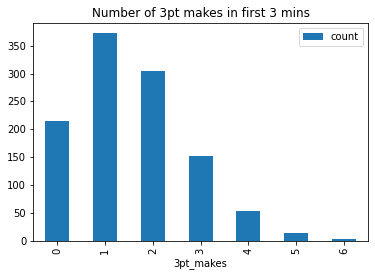

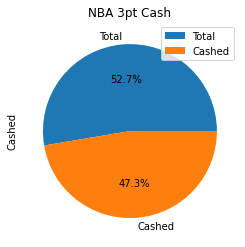

In [74]:
import pandas
from builtins import round

df3x2Breakdown = spark.sql("""select 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by 3pt_makes
order by 3pt_makes""")

df3x2Breakdown.show()

df3x2Breakdown.toPandas().plot(kind='bar', x='3pt_makes', y='count', title='Number of 3pt makes in first 3 mins')



total_games = spark.sql("""select count(distinct game_id) as total_games from all_shots""").first().total_games

cashed = spark.sql("""select count(3pt_makes) as cash from 3x2_results
where 3pt_makes >= 2""").first().cash

dfTotals = pandas.DataFrame({"Cashed": [total_games - cashed, cashed]}, index=["Total", "Cashed"])

dfTotals.plot(kind='pie', y='Cashed', autopct='%1.1f%%', title='NBA 3pt Cash')

print("{} / {} = {}%".format(cashed, total_games, round((cashed / total_games) * 100, 2)))

In [75]:
import pandas

df3x2TeamBreakdown = spark.sql("""select game_number, home_team, away_team, 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by game_number, home_team, away_team, 3pt_makes
order by home_team, 3pt_makes""")

df3x2TeamBreakdown.createOrReplaceTempView("3x2_team_breakdown")

df3x2TeamBreakdown.show()

df3x2TeamBreakdownMakes = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes >= 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMakes.createOrReplaceTempView("3x2_team_breakdown_makes")

df3x2TeamBreakdownMakes.show()

df3x2TeamBreakdownMisses = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes < 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMisses.createOrReplaceTempView("3x2_team_breakdown_misses")

df3x2TeamBreakdownMisses.show()

+-----------+---------+---------+---------+-----+
|game_number|home_team|away_team|3pt_makes|count|
+-----------+---------+---------+---------+-----+
|        239|      ATL|      CHO|        0|    1|
|        333|      ATL|      PHI|        0|    1|
|        646|      ATL|      MIL|        0|    1|
|        775|      ATL|      PHO|        0|    1|
|        609|      ATL|      MIA|        0|    1|
|        994|      ATL|      LAC|        1|    1|
|        936|      ATL|      CHI|        1|    1|
|        632|      ATL|      NYK|        1|    1|
|       1045|      ATL|      MEM|        1|    1|
|        253|      ATL|      OKC|        1|    1|
|        726|      ATL|      BOS|        1|    1|
|        676|      ATL|      MIA|        2|    1|
|        382|      ATL|      BRK|        2|    1|
|        119|      ATL|      UTA|        2|    1|
|        292|      ATL|      NYK|        2|    1|
|        832|      ATL|      SAS|        2|    1|
|        751|      ATL|      TOR|        2|    1|


In [76]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2TeamMakes = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes
    group by away_team""")
)

df3x2TeamMakes.createOrReplaceTempView("3x2_team_makes")

df3x2TeamMakesFinal = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMisses = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses
    group by away_team""")
)

df3x2TeamMisses.createOrReplaceTempView("3x2_team_misses")

df3x2TeamMissesFinal = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGames = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes
    union all
    select team, count
    from 3x2_team_misses
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdown = df3x2TeamMissesFinal.join(df3x2TeamMakesFinal, on='team').join(dfTeamTotalGames, on='team').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .select('rank', 'team', 'make_count', 'miss_count', 'total_games', 'make_pct')
dfFullTeamBreakdown.createOrReplaceTempView("full_team_breakdown")

dfFullTeamBreakdown.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| HOU|        47|        28|         75|   62.67|
|   2| NYK|        44|        30|         74|   59.46|
|   3| ATL|        43|        31|         74|   58.11|
|   4| BRK|        40|        34|         74|   54.05|
|   5| DEN|        40|        35|         75|   53.33|
|   6| ORL|        40|        35|         75|   53.33|
|   7| BOS|        39|        35|         74|    52.7|
|   8| MIL|        39|        35|         74|    52.7|
|   9| MIN|        39|        36|         75|    52.0|
|  10| GSW|        38|        36|         74|   51.35|
|  11| UTA|        38|        36|         74|   51.35|
|  12| TOR|        37|        37|         74|    50.0|
|  13| OKC|        36|        38|         74|   48.65|
|  14| CHI|        36|        38|         74|   48.65|
|  15| MIA|        36|        39|         75|    48.0|
|  16| SAC

In [77]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_15 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85*3

df3x2TeamBreakdownMakesLast15 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMissesLast15 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMakesLast15.createOrReplaceTempView("3x2_team_breakdown_makes_last_15")
df3x2TeamBreakdownMissesLast15.createOrReplaceTempView("3x2_team_breakdown_misses_last_15")

df3x2TeamMakesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_15
    group by away_team""")
)

df3x2TeamMakesLast15.createOrReplaceTempView("3x2_team_makes_last_15")

df3x2TeamMakesFinalLast15 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_15
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_15
    group by away_team""")
)

df3x2TeamMissesLast15.createOrReplaceTempView("3x2_team_misses_last_15")

df3x2TeamMissesFinalLast15 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_15
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast15 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_15
    union all
    select team, count
    from 3x2_team_misses_last_15
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast15 = df3x2TeamMissesFinalLast15.join(df3x2TeamMakesFinalLast15, on='team').join(dfTeamTotalGamesLast15, on='team').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .select('rank', 'team', 'make_count', 'miss_count', 'total_games', 'make_pct')
dfFullTeamBreakdownLast15.createOrReplaceTempView("full_team_breakdown_last_15")

dfFullTeamBreakdownLast15.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| BOS|        12|         4|         16|    75.0|
|   2| ORL|        12|         4|         16|    75.0|
|   3| CHO|        10|         6|         16|    62.5|
|   4| SAC|         9|         7|         16|   56.25|
|   5| MIL|         9|         7|         16|   56.25|
|   6| UTA|        10|         8|         18|   55.56|
|   7| BRK|         9|         8|         17|   52.94|
|   8| DAL|         9|         8|         17|   52.94|
|   9| MEM|         9|         8|         17|   52.94|
|  10| DEN|         9|         9|         18|    50.0|
|  11| ATL|         9|         9|         18|    50.0|
|  12| NOP|         8|         9|         17|   47.06|
|  13| TOR|         8|        10|         18|   44.44|
|  14| OKC|         8|        10|         18|   44.44|
|  15| MIN|         8|        10|         18|   44.44|
|  16| HOU

In [78]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_5 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85

df3x2TeamBreakdownMakesLast5 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMissesLast5 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMakesLast5.createOrReplaceTempView("3x2_team_breakdown_makes_last_5")
df3x2TeamBreakdownMissesLast5.createOrReplaceTempView("3x2_team_breakdown_misses_last_5")

df3x2TeamMakesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_5
    group by away_team""")
)

df3x2TeamMakesLast5.createOrReplaceTempView("3x2_team_makes_last_5")

df3x2TeamMakesFinalLast5 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_5
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_5
    group by away_team""")
)

df3x2TeamMissesLast5.createOrReplaceTempView("3x2_team_misses_last_5")

df3x2TeamMissesFinalLast5 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_5
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast5 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_5
    union all
    select team, count
    from 3x2_team_misses_last_5
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast5 = df3x2TeamMissesFinalLast5.join(df3x2TeamMakesFinalLast5, on='team', how="outer").join(dfTeamTotalGamesLast5, on='team', how="outer").withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .selectExpr('rank', 'team', "coalesce(make_count, 0) as make_count", 'coalesce(miss_count, 0) as miss_count', 'total_games', 'coalesce(make_pct, 0) as make_pct')
dfFullTeamBreakdownLast5.createOrReplaceTempView("full_team_breakdown_last_5")

dfFullTeamBreakdownLast5.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| CHO|         4|         1|          5|    80.0|
|   2| MIL|         4|         1|          5|    80.0|
|   3| BOS|         4|         1|          5|    80.0|
|   4| ORL|         4|         2|          6|   66.67|
|   5| UTA|         4|         2|          6|   66.67|
|   6| SAC|         3|         2|          5|    60.0|
|   7| ATL|         3|         3|          6|    50.0|
|   8| BRK|         3|         3|          6|    50.0|
|   9| DAL|         3|         3|          6|    50.0|
|  10| LAC|         2|         2|          4|    50.0|
|  11| MEM|         3|         3|          6|    50.0|
|  12| NOP|         3|         3|          6|    50.0|
|  13| OKC|         3|         3|          6|    50.0|
|  14| TOR|         3|         3|          6|    50.0|
|  15| WAS|         3|         3|          6|    50.0|
|  16| GSW

In [79]:
import pandas

dfFullTeamBreakdownWithRecent = spark.sql("""select ftb.*, concat(ftb5.make_count, '-', ftb5.miss_count) as make_miss_recent_5, concat(ftb15.make_count, '-', ftb15.miss_count) as make_miss_recent_15,
case when (ftb5.make_count / (ftb5.make_count + ftb5.miss_count)) * 100 > ftb.make_pct then 'up' else 'down' end as trend_recent_5
from full_team_breakdown ftb
inner join full_team_breakdown_last_15 ftb15 on ftb.team = ftb15.team
inner join full_team_breakdown_last_5 ftb5 on ftb.team = ftb5.team
order by ftb.rank
""")

dfFullTeamBreakdownWithRecent.cache()

dfFullTeamBreakdownWithRecent.createOrReplaceTempView("full_team_breakdown_with_recent")

dfFullTeamBreakdownWithRecent.show()

+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+
|rank|team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+
|   1| HOU|        47|        28|         75|   62.67|               2-5|               8-12|          down|
|   2| NYK|        44|        30|         74|   59.46|               2-4|               6-11|          down|
|   3| ATL|        43|        31|         74|   58.11|               3-3|                9-9|          down|
|   4| BRK|        40|        34|         74|   54.05|               3-3|                9-8|          down|
|   5| DEN|        40|        35|         75|   53.33|               2-4|                9-9|          down|
|   6| ORL|        40|        35|         75|   53.33|               4-2|               12-4|            up|
|   7| BOS|        

In [80]:
from pyspark.sql.functions import col, round, row_number, lit, dense_rank
from pyspark.sql.window import Window

# Get Shot breakdown per team in last 5 games
df3x2_total_shots_with_game_number = spark.sql("""SELECT game_id, relevant_team as offense_team, 
case when relevant_team != home_team then home_team else away_team end as defense_team, sum(total_shots) as total_shots
from 3x2_detail
group by game_id, relevant_team, case when relevant_team != home_team then home_team else away_team end
""").withColumn("game_number", dense_rank().over(Window.partitionBy(lit(0)).orderBy(col("game_id"))))

# df3x2_total_shots_with_game_number.show()

df3x2_total_shots_last_5 = df3x2_total_shots_with_game_number.filter(col("game_number") >= game_number_last_5)
df3x2_total_shots_last_5.createOrReplaceTempView("3x2_total_shots_last_5")

df3x2_all_shots_last_5 = spark.sql("""SELECT *, 
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 3 and shot_result = 'MAKE'), 0) as offense_3_makes,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 3), 0) as offense_3_shots,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 2 and shot_result = 'MAKE'), 0) as offense_2_makes,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 2), 0) as offense_2_shots
from 3x2_total_shots_last_5 a
""")
df3x2_all_shots_last_5.createOrReplaceTempView("3x2_all_shots_last_5")

# df3x2_all_shots_last_5.show()

df3x2_all_stats_last_5 = spark.sql("""SELECT *, 
    round(offense_3_makes / 3, 2) as offense_3_makes_per_min,
    round(offense_3_shots / 3, 2) as offense_3_shots_per_min,
    round(offense_3_shots / (offense_3_shots + offense_2_shots) * 100) as offense_3_atmpt_pct
from 3x2_all_shots_last_5 a
""")
df3x2_all_stats_last_5.createOrReplaceTempView("3x2_all_stats_last_5")
# df3x2_all_stats_last_5.show()

df3x2_rollup_last_5_pt1 = spark.sql("""SELECT offense_team as team, round(avg(offense_3_makes), 1) as offense_3_makes, round(avg(offense_3_shots), 1) as offense_3_shots, round(avg(total_shots), 1) as total_shots
from 3x2_all_stats_last_5
group by offense_team
""")
df3x2_rollup_last_5_pt1.createOrReplaceTempView("3x2_rollup_last_5_pt1")

df3x2_rollup_last_5_pt2 = spark.sql("""select *, 
    coalesce((select round(avg(offense_3_makes), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_3_makes,
    coalesce((select round(avg(offense_3_shots), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_3_shots,
    coalesce((select round(avg(total_shots), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_total_shots
    from 3x2_rollup_last_5_pt1 a

""")
df3x2_rollup_last_5_pt2.createOrReplaceTempView("df3x2_rollup_last_5")
df3x2_rollup_last_5_pt2.cache()
df3x2_rollup_last_5_pt2.show()


+----+---------------+---------------+-----------+---------------+---------------+-------------------+
|team|offense_3_makes|offense_3_shots|total_shots|defense_3_makes|defense_3_shots|defense_total_shots|
+----+---------------+---------------+-----------+---------------+---------------+-------------------+
| GSW|            0.6|            2.4|        5.4|            1.2|            3.8|                6.4|
| DET|            0.3|            2.0|        5.5|            0.3|            2.0|                6.0|
| LAL|            0.6|            2.0|        6.6|            0.6|            2.0|                5.6|
| NYK|            1.2|            3.0|        5.3|            0.7|            2.2|                4.7|
| CHO|            1.4|            1.8|        4.2|            1.4|            2.6|                5.4|
| LAC|            0.8|            1.3|        5.5|            1.3|            2.0|                5.0|
| UTA|            1.7|            3.5|        5.5|            0.7|       

In [85]:
import pandas
from builtins import round
from basketball_reference_scraper.seasons import get_schedule
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR
import urllib.request, json
from scipy.stats import binom
from oddscalculator import *


games = get_schedule(2022, playoffs=False)

todaysGames = games.loc[games["DATE"].dt.strftime("%Y-%m-%d") == pd.to_datetime("today").strftime("%Y-%m-%d")]

print("Found {} games for today".format(len(todaysGames)))

# Get FD odds for today's games

fd_odds = {}

with urllib.request.urlopen("https://sbapi.nj.sportsbook.fanduel.com/api/content-managed-page?betexRegion=GBR&capiJurisdiction=intl&currencyCode=USD&exchangeLocale=en_US&includePrices=true&includeRaceCards=false&language=en&regionCode=NAMERICA&timezone=America%2FNew_York&includeMarketBlurbs=true&_ak=FhMFpcPWXMeyZxOx&page=CUSTOM&customPageId=nba") as url:
    data = json.loads(url.read().decode())
    for attr, market in data['attachments']['markets'].items():
        if 'marketType' in market and market['marketType'] == "2_OR_MORE_3_POINT_FGS_MADE_IN_THE_FIRST_3_MINUTES":
            mkt_key = market['marketName'].split("-")[1].replace("/", "_").replace(" v ", "_").strip()
            fd_odds[mkt_key] = []
            for runner in market['runners']:
                fd_odds[mkt_key].append({ runner['runnerName']: runner['winRunnerOdds']['americanDisplayOdds']['americanOdds'] })
    print(fd_odds)

replacement_codes = {
    'BRK': 'BKN',
    #'BKN': 'BRK',
    'CHO': 'CHA',
    'PHO': 'PHX'
}

# Get 3pt make %
three_pt_make_pct = spark.sql("""select ROUND(sum(three_pt_made) / sum(three_pt_attempts) * 100, 2) as three_pt_make_pct
from 3x2_player_shot_breakdown_pt2""").collect()[0].three_pt_make_pct

print("NBA 3x2 make %: {}%".format(three_pt_make_pct))

for index, game in todaysGames.iterrows():
    homeTeamCode = TEAM_TO_TEAM_ABBR[game["HOME"].upper()]
    awayTeamCode = TEAM_TO_TEAM_ABBR[game["VISITOR"].upper()]
    dfMatchup = spark.sql("""select a.*, b.offense_3_makes, offense_3_shots, b.total_shots, b.defense_3_makes, b.defense_3_shots, b.defense_total_shots from full_team_breakdown_with_recent a
     inner join df3x2_rollup_last_5 b on a.team = b.team
     where a.team in ('{}', '{}')"""
        .format(homeTeamCode, awayTeamCode))

    dfMatchup.show()

    dfMatchup = dfMatchup.collect()

    total3s = dfMatchup[0].offense_3_shots + dfMatchup[1].offense_3_shots
    probYes = binom.sf(k=1, n=total3s, p=three_pt_make_pct/100)
    probNo = 1 - probYes

    try:
        team1_pct = dfMatchup[0].make_pct
    except:
        team1_pct = 0

    try:
        team1_pct_recent_5 = (int(dfMatchup[0].make_miss_recent_5.split("-")[0]) / 
            (int(dfMatchup[0].make_miss_recent_5.split("-")[0]) + int(dfMatchup[0].make_miss_recent_5.split("-")[1]))) * 100
    except:
        team1_pct_recent_5 = 0

    try:
        team1_pct_recent_15 = (int(dfMatchup[0].make_miss_recent_15.split("-")[0]) / 
            (int(dfMatchup[0].make_miss_recent_15.split("-")[0]) + int(dfMatchup[0].make_miss_recent_15.split("-")[1]))) * 100
    except:
        team1_pct_recent_15 = 0
    
    try:
        team2_pct = dfMatchup[1].make_pct
    except:
        team2_pct = 0

    try:
        team2_pct_recent_5 = (int(dfMatchup[1].make_miss_recent_5.split("-")[0]) / 
            (int(dfMatchup[1].make_miss_recent_5.split("-")[0]) + int(dfMatchup[1].make_miss_recent_5.split("-")[1]))) * 100
    except:
        team2_pct_recent_5 = 0

    try:
        team2_pct_recent_15 = (int(dfMatchup[1].make_miss_recent_15.split("-")[0]) / 
            (int(dfMatchup[1].make_miss_recent_15.split("-")[0]) + int(dfMatchup[1].make_miss_recent_15.split("-")[1]))) * 100
    except:
        team2_pct_recent_15 = 0

    total_pct = (team1_pct + team2_pct) / 2
    total_pct_recent_5 = (team1_pct_recent_5 + team2_pct_recent_5) / 2
    total_pct_recent_15 = (team1_pct_recent_15 + team2_pct_recent_15) / 2

    dec_odds = 1 / (total_pct / 100)
    dec_odds_recent_5 = 1 / (total_pct_recent_5 / 100)
    dec_odds_recent_15 = 1 / (total_pct_recent_15 / 100)
    dec_odds_yes = 1 / (probYes)
    dec_odds_no = 1 / (probNo)

    american_odds = DecimalOdds(float(dec_odds)).american
    american_odds_recent_5 = DecimalOdds(float(dec_odds_recent_5)).american
    american_odds_recent_15 = DecimalOdds(float(dec_odds_recent_15)).american
    american_odds_probability = DecimalOdds(float(dec_odds_yes)).american

    fdAwayTeam = awayTeamCode
    if fdAwayTeam in replacement_codes:
        fdAwayTeam = replacement_codes[awayTeamCode]

    fdHomeTeam = homeTeamCode
    if fdHomeTeam in replacement_codes:
        fdHomeTeam = replacement_codes[homeTeamCode]

    print("Percentage [overall]: {}%, American odds: {:+}".format(round(total_pct, 2), round(american_odds)))
    print("Percentage [recent 15]: {}%, American odds: {:+}".format(round(total_pct_recent_15, 2), round(american_odds_recent_15)))
    print("Percentage [recent 5]: {}%, American odds: {:+}".format(round(total_pct_recent_5, 2), round(american_odds_recent_5)))
    print("Percentage [recent 5 3PA]: {}%, American odds: {:+}".format(round(probYes * 100, 2), int(round(american_odds_probability))))
    try:
        fdOdds = 0
        if fdAwayTeam + "_" + fdHomeTeam in fd_odds:
            fdOdds = fd_odds[fdAwayTeam + "_" + fdHomeTeam]       
        else:
            fdOdds = fd_odds[fdHomeTeam + "_" + fdAwayTeam]
        
        print("Fanduel Odds => " + str(fdOdds))

        ev_3pa_yes = (probYes) * (100.0 * (AmericanOdds(fdOdds[0]['Yes']).decimal - 1.0)) - (1.0 - probYes) * (100.0)
        ev_3pa_no = (probNo) * (100.0 * (AmericanOdds(fdOdds[1]['No']).decimal - 1.0)) - (1.0 - probNo) * (100.0)
        print("EV 3PA Yes: {:+}%".format(round(ev_3pa_yes, 2)))
        print("EV 3PA No: {:+}%".format(round(ev_3pa_no, 2)))
    except:
        print("************* No Fanduel odds found for {} vs {} **************".format(fdAwayTeam, fdHomeTeam))
    print("")
    print("")

Found 7 games for today
{'LAL_NOP': [{'Yes': 108}, {'No': -132}], 'UTA_DAL': [{'Yes': -110}, {'No': -110}], 'CHA_BKN': [{'Yes': -122}, {'No': 100}]}
NBA 3x2 make %: 37.38%
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+---------------+---------------+-----------+---------------+---------------+-------------------+
|rank|team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|offense_3_makes|offense_3_shots|total_shots|defense_3_makes|defense_3_shots|defense_total_shots|
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+---------------+---------------+-----------+---------------+---------------+-------------------+
|   2| NYK|        44|        30|         74|   59.46|               2-4|               6-11|          down|            1.2|            3.0|        5.3|            0.7|            2.2|                4.7|
|  29| D

In [82]:
# Get starting lineups for today's games
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = "https://www.rotowire.com/basketball/nba-lineups.php"
soup = BeautifulSoup(requests.get(url).content, "html.parser")

teams = {}

for team in soup.select(".lineup__team"):
    team_name = team.get_text(strip=True, separator="\n")
    if len(team_name) == 3:
        # print(team_name)
        teams[team_name] = []
team_indexes = list(teams)
for index, lineup in enumerate(soup.select(".lineup__main")):
    for player in lineup.select("ul:first-child > li > a")[:5]:
        # print(player.get_text(strip=True, separator="\n"))
        names = player.get_text(strip=True, separator="\n").split(" ")
        name = names[0][0] + ". " + names[1]
        teams[team_indexes[index*2]].append(name)
    for player in lineup.select("ul:last-child > li > a")[:5]:
        # print(player.get_text(strip=True, separator="\n"))
        names = player.get_text(strip=True, separator="\n").split(" ")
        name = names[0][0] + ". " + names[1]
        teams[team_indexes[index*2 + 1]].append(name)

df = pd.DataFrame(teams)
print(df)


           NYK            DET            MIN          BOS          PHI  \
0     A. Burks      C. Joseph    P. Beverley     M. Smart     T. Maxey   
1  E. Fournier  C. Cunningham     D. Russell     J. Brown    J. Harden   
2   R. Barrett         S. Bey     A. Edwards     J. Tatum  M. Thybulle   
3    J. Randle      M. Bagley  J. Vanderbilt  G. Williams    T. Harris   
4  M. Robinson     I. Stewart       K. Towns  R. Williams    J. Embiid   

          PHX          GSW               WAS           LAL             NOP  \
0     C. Paul     J. Poole     T. Satoransky  R. Westbrook       D. Graham   
1   D. Booker  K. Thompson  K. Caldwell-Pope     A. Reaves     C. McCollum   
2  M. Bridges   A. Wiggins        C. Kispert      L. James       B. Ingram   
3  J. Crowder   J. Kuminga      R. Hachimura    W. Gabriel        H. Jones   
4    D. Ayton     D. Green      K. Porzingis     D. Howard  J. Valanciunas   

              UTA              DAL            CHA          BKN  
0       M. Conley    